# Documentation

**Author:** Anirudh  
**Date:** 16/june/2025  

### Details:
- **Modeling:** Using Linear mixed models now to study the longitudinal changes with respective to Diagnosis (Given BL_DX how cognitive changes overtime with sleep variables)
    - Two types of models to be made : 1. MRI, Cognitive, Sociodemographics. 2. MRI, Cognitive, APOE4, BMI, Cardiovascular risks [Using RID as random effect]
- **Transitions:** Check transitions for Diagnosis and NPIKSEV over time.
    - Flat = no changes 
    - Improves  
    - Worsen 
    - Mixed changes 
- **Changes:** 
    - Using Adjusted_Age instead of AGE.
    - Removing ICV as a covariate for MRI outcomes, instead using it as a predictor
    - Including Viscode/ Adjusted_Age in the model
    - Renamed model to have: outcome_sleep_var
    - Changed the plots now for each sleep_var inclusion
    - Saved the two models after including sociodemographic features into the 2nd model

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
merge =pd.read_csv("Latest_all_in_one.csv")

In [3]:
merge

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,Adjusted_Age,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,0,0,0,0,791.846918,1078.037276,1512.146246,6716.630454,8350.166431,...,81.300000,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062
1,3,0,0,0,0,958.133790,938.695742,1614.977833,6975.019609,7541.152761,...,81.798289,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670
2,3,0,0,0,0,676.398197,1094.889167,1440.387527,6116.780815,7896.178469,...,82.299316,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034
3,3,0,0,0,0,442.103700,1037.524095,1379.850263,6111.576649,7557.134067,...,83.298630,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605
4,5,0,0,0,0,2376.161479,1881.167048,2169.129587,9288.203483,10896.464856,...,73.700000,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,1425,0,0,0,0,1406.252121,2290.512715,1546.298629,10290.524783,11785.897409,...,77.606840,2,0.0,0.0,0.004549,-1.661,-1.078,0.739,-2.517,-0.826
2084,1427,0,0,0,0,1868.036354,2135.917249,2043.228422,9407.406634,12729.944577,...,69.600000,2,0.0,0.0,72.926002,-0.366,-1.746,-1.530,-0.492,-2.042
2085,1427,0,0,0,0,1568.588612,2109.721786,2000.099965,9038.817478,12770.942225,...,70.079124,2,0.0,0.0,72.926002,-1.445,-1.642,-1.813,-1.640,-1.788
2086,1427,0,0,0,0,1723.941992,2188.880920,1989.621379,8826.900230,12048.758467,...,70.604790,2,1.0,2.0,72.926002,-1.764,-1.625,-0.656,-0.946,-2.047


In [4]:
sleep_cols = ['Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
merge['MHSleep'] = merge[sleep_cols].sum(axis=1)

In [5]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'MHSleep']
mri_outcomes = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
]

In [6]:
set(merge.columns) - set(mri_outcomes) - set(cognitive_outcomes) - set(sleep_vars)

{'APOE4',
 'Adjusted_Age',
 'BMI',
 'DX',
 'DX_bl',
 'Insomnia',
 'MH',
 'PTEDUCAT',
 'PTETHCAT',
 'PTGENDER',
 'PTMARRY',
 'PTRACCAT',
 'RID',
 'Restless_Legs',
 'Sleep_Apnea',
 'Sleep_Disturbance_Other',
 'VISCODE'}

In [7]:
merge_scale = merge.copy()

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in merge_scale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

for column in sleep_vars:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

In [9]:
label_encoders 

{'VISCODE': LabelEncoder(),
 'DX': LabelEncoder(),
 'DX_bl': LabelEncoder(),
 'PTGENDER': LabelEncoder(),
 'PTETHCAT': LabelEncoder(),
 'PTRACCAT': LabelEncoder(),
 'PTMARRY': LabelEncoder(),
 'NPIK': LabelEncoder(),
 'NPIKSEV': LabelEncoder(),
 'MHSleep': LabelEncoder()}

In [10]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes  +
    mri_outcomes + ['BMI', 'Adjusted_Age','MHSleep']
)
scaler = StandardScaler()
merge_scale[continuous_vars] = scaler.fit_transform(
    merge_scale[continuous_vars])

In [11]:
categorical_vars = ['DX','DX_bl','PTETHCAT']
merge_scale= pd.get_dummies(
    merge_scale, columns=categorical_vars, drop_first=True)

In [12]:
set(merge_scale.columns) - set(mri_outcomes) - \
    set(cognitive_outcomes) - set(sleep_vars)

{'APOE4',
 'Adjusted_Age',
 'BMI',
 'DX_1',
 'DX_2',
 'DX_bl_1',
 'DX_bl_2',
 'Insomnia',
 'MH',
 'PTEDUCAT',
 'PTETHCAT_1',
 'PTETHCAT_2',
 'PTGENDER',
 'PTMARRY',
 'PTRACCAT',
 'RID',
 'Restless_Legs',
 'Sleep_Apnea',
 'Sleep_Disturbance_Other',
 'VISCODE'}

In [13]:
model1_preds_mri = ['Adjusted_Age', 'DX_1', 'DX_2', 'PTEDUCAT',
                    'PTETHCAT_1', 'PTETHCAT_2', 'PTGENDER', 'PTMARRY', 'PTRACCAT']
model1_preds_cog = model1_preds_mri

In [14]:
merge.groupby('DX')['RID'].nunique()

DX
CN          189
Dementia    200
MCI         248
Name: RID, dtype: int64

In [15]:
merge.groupby('DX_bl')['RID'].nunique()

DX_bl
AD      106
CN      178
LMCI    238
Name: RID, dtype: int64

In [16]:
from collections import defaultdict

sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join( model1_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [40]:
# import pickle
# for sleep_var in sleep_vars:
#     with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'wb') as f:
#         pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

#     with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'wb') as f:
#         pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [17]:
LMM_results_cognitive_df = pd.DataFrame(sleep_model_results['cognitive'])
LMM_results_mri_df = pd.DataFrame(sleep_model_results['mri'])

In [42]:
# import pickle

# cog_frames = []
# for sleep_var in sleep_vars:
#     with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'rb') as f:
#         cognitive_results = pickle.load(f)
#         cog_frames.append(pd.DataFrame(cognitive_results))

# LMM_results_cognitive_df = pd.concat(cog_frames, ignore_index=True)

# mri_frames = []
# for sleep_var in sleep_vars:
#     with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'rb') as f:
#         mri_results = pickle.load(f)
#         mri_frames.append(pd.DataFrame(mri_results))

# LMM_results_mri_df = pd.concat(mri_frames, ignore_index=True)

In [18]:
def flatten_model_dict_df(nested_df):
    records = []
    for col in nested_df.columns:
        for cell in nested_df[col]:
            if isinstance(cell, dict):
                records.append(cell)
    return pd.DataFrame(records)

In [19]:
LMM_results_cognitive_df = flatten_model_dict_df(LMM_results_cognitive_df)
LMM_results_mri_df = flatten_model_dict_df(LMM_results_mri_df)

In [20]:
flat_cog = LMM_results_cognitive_df[~LMM_results_cognitive_df['Feature'].isin(['Intercept', 'Group Var'])]
flat_mri = LMM_results_mri_df[~LMM_results_mri_df['Feature'].isin(['Intercept', 'Group Var'])]

In [21]:
import re


def clean_feature_name(feature):
    match = re.match(r"Q\('(.+)'\)", feature)
    return match.group(1) if match else feature

flat_cog['Feature'] = flat_cog['Feature'].apply(clean_feature_name)
flat_mri['Feature'] = flat_mri['Feature'].apply(clean_feature_name)

C:\Users\anisr\AppData\Local\Temp\ipykernel_17984\3667836127.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].apply(clean_feature_name)
C:\Users\anisr\AppData\Local\Temp\ipykernel_17984\3667836127.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['Feature'] = flat_mri['Feature'].apply(clean_feature_name)


In [22]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT_1': 'Not Hisp/Latino',
    'PTETHCAT_2': 'Unknown Eth'
}
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

C:\Users\anisr\AppData\Local\Temp\ipykernel_17984\255279401.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
C:\Users\anisr\AppData\Local\Temp\ipykernel_17984\255279401.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)


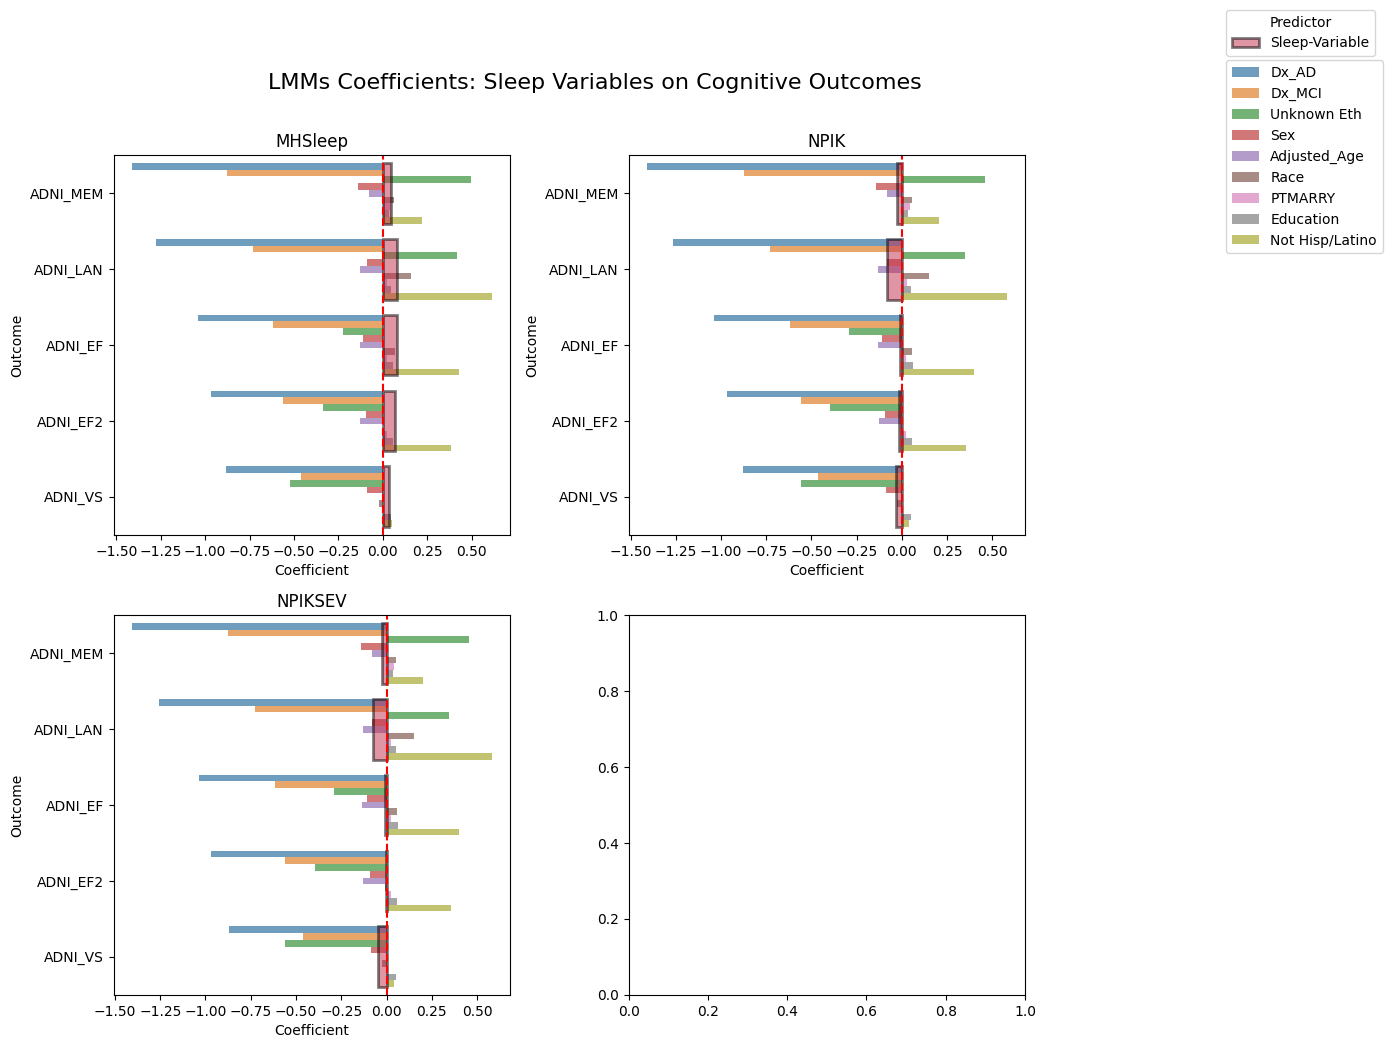

In [23]:
import math


def plot_lmms_result(df, domain='Cognitive', n_cols=2):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(
        n_cols*6, n_rows*5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var

        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )

        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1],
               bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')
    fig.suptitle(
        f'LMMs Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()


plot_lmms_result(flat_cog.sort_values(by='Coefficient'), domain='Cognitive', n_cols=2)

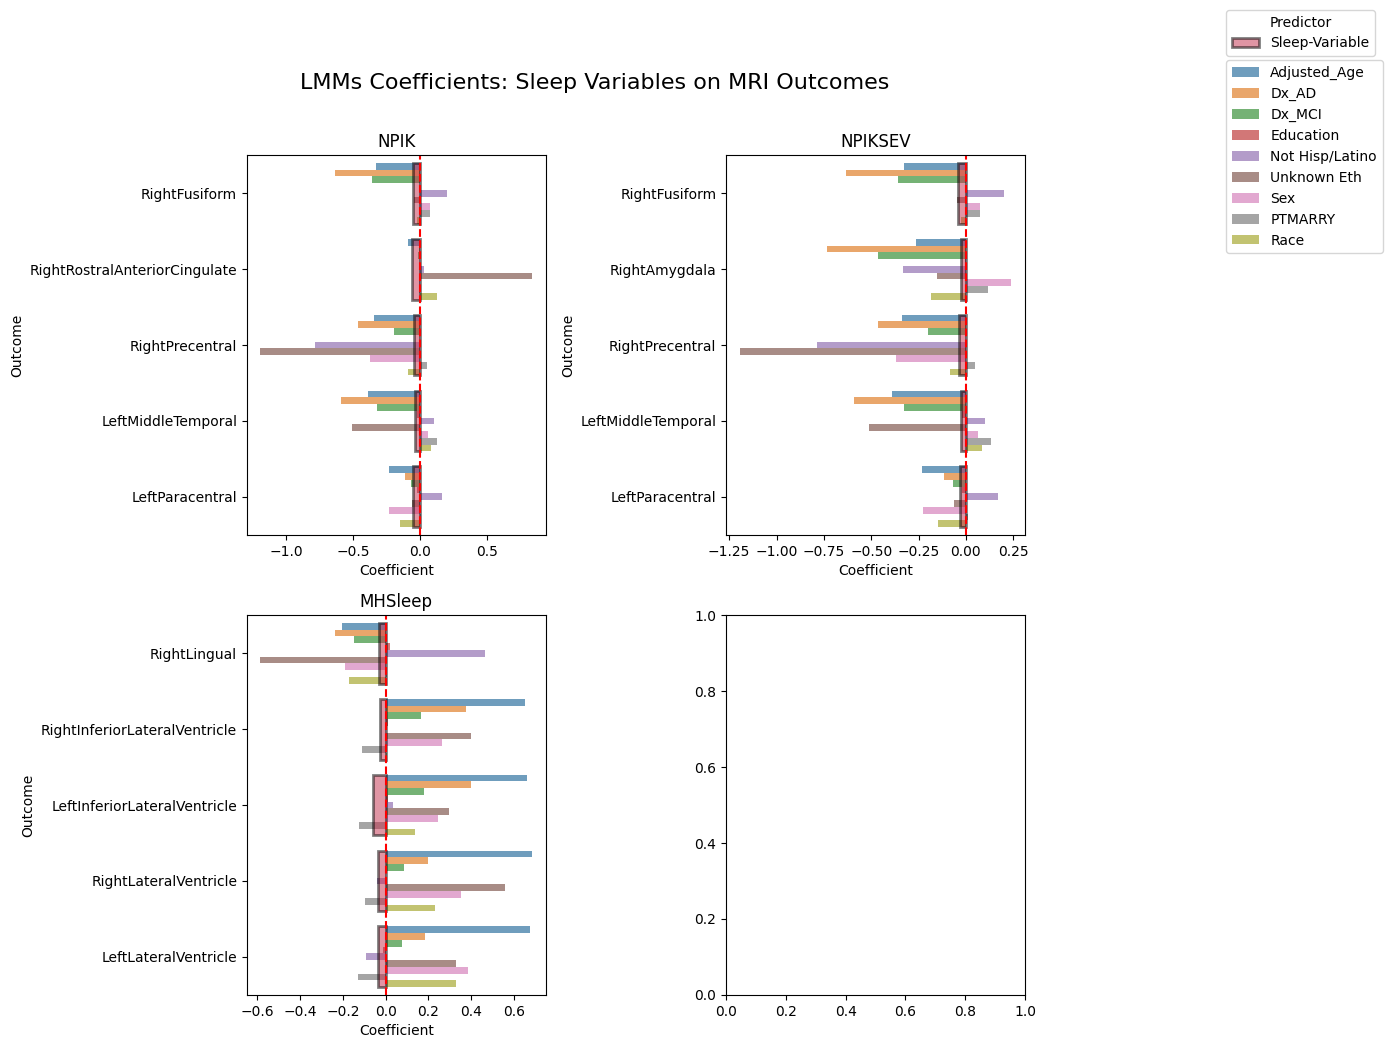

In [24]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[flat_mri['Sleep_Variable'] == sleep_var]

    top_outcomes = (
        df_plot[df_plot['Feature'] == sleep_var].sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )

    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top)

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lmms_result(df_top_all, domain='MRI')

In [25]:
model2_preds_cog = ['APOE4', 'BMI','MH',] + model1_preds_cog
model2_preds_mri = ['APOE4', 'BMI', 'MH',] + model1_preds_mri

In [26]:
model2_preds_cog 

['APOE4',
 'BMI',
 'MH',
 'Adjusted_Age',
 'DX_1',
 'DX_2',
 'PTEDUCAT',
 'PTETHCAT_1',
 'PTETHCAT_2',
 'PTGENDER',
 'PTMARRY',
 'PTRACCAT']

In [27]:
from collections import defaultdict

sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join( model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [28]:
LMM_results_cognitive_df_sd = pd.DataFrame(sleep_model_results['cognitive'])
LMM_results_mri_df_sd = pd.DataFrame(sleep_model_results['mri'])

In [54]:
# import pickle
# for sleep_var in sleep_vars:
#     with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
#         pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

#     with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
#         pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [29]:
LMM_results_cog_df = flatten_model_dict_df(LMM_results_cognitive_df_sd)
LMM_results_mri_df = flatten_model_dict_df(LMM_results_mri_df_sd)

In [56]:
# cog_frames = []
# mri_frames = []

# for sleep_var in sleep_vars:
#     with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
#         cognitive_results = pickle.load(f)
#         cog_frames.append(pd.DataFrame(cognitive_results))

#     with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
#         mri_results = pickle.load(f)
#         mri_frames.append(pd.DataFrame(mri_results))

# LMM_results_cognitive_df_sd = pd.concat(cog_frames, ignore_index=True)
# LMM_results_mri_df_sd = pd.concat(mri_frames, ignore_index=True)

In [30]:
LMM_results_cognitive_df_sd = LMM_results_cognitive_df[~LMM_results_cognitive_df['Feature'].isin( ['Group Var','Intercept'])]
LMM_results_mri_df_sd = LMM_results_mri_df[~LMM_results_mri_df['Feature'].isin( ['Group Var', 'Intercept'])]

In [31]:
flat_cog['Feature'] = LMM_results_cognitive_df_sd['Feature'].apply(clean_feature_name)
flat_mri['Feature'] = LMM_results_mri_df_sd['Feature'].apply(clean_feature_name)

C:\Users\anisr\AppData\Local\Temp\ipykernel_17984\3738176521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = LMM_results_cognitive_df_sd['Feature'].apply(clean_feature_name)


In [32]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT_1': 'Not Hisp/Latino',
    'PTETHCAT_2': 'Unknown Eth'
}
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

C:\Users\anisr\AppData\Local\Temp\ipykernel_17984\255279401.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)


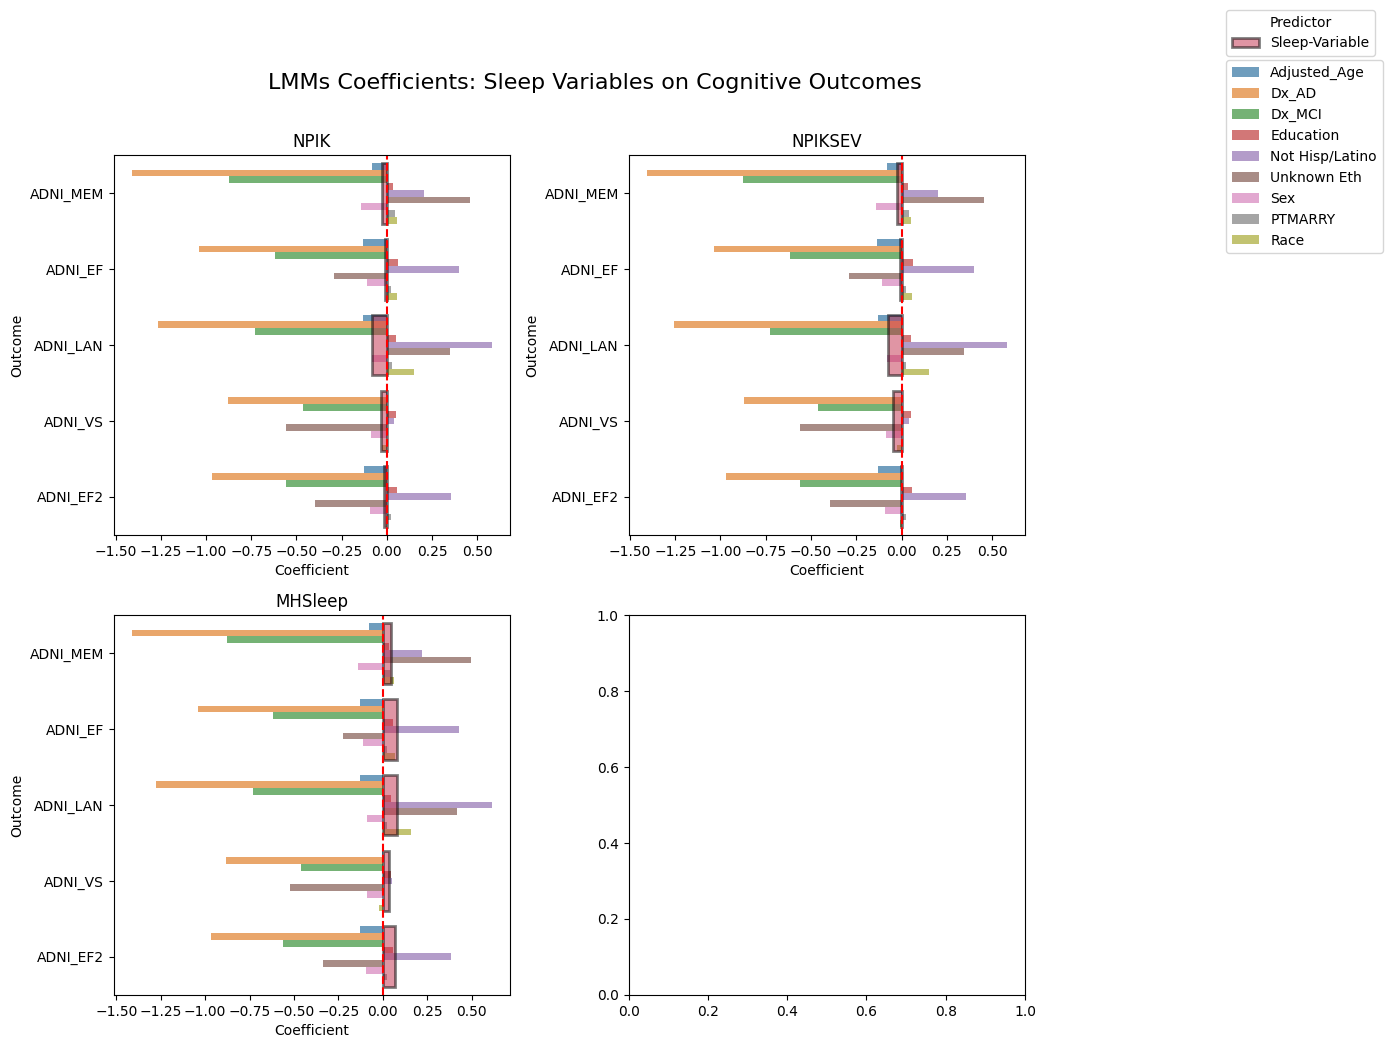

In [33]:
plot_lmms_result(flat_cog, domain='Cognitive', n_cols=2)

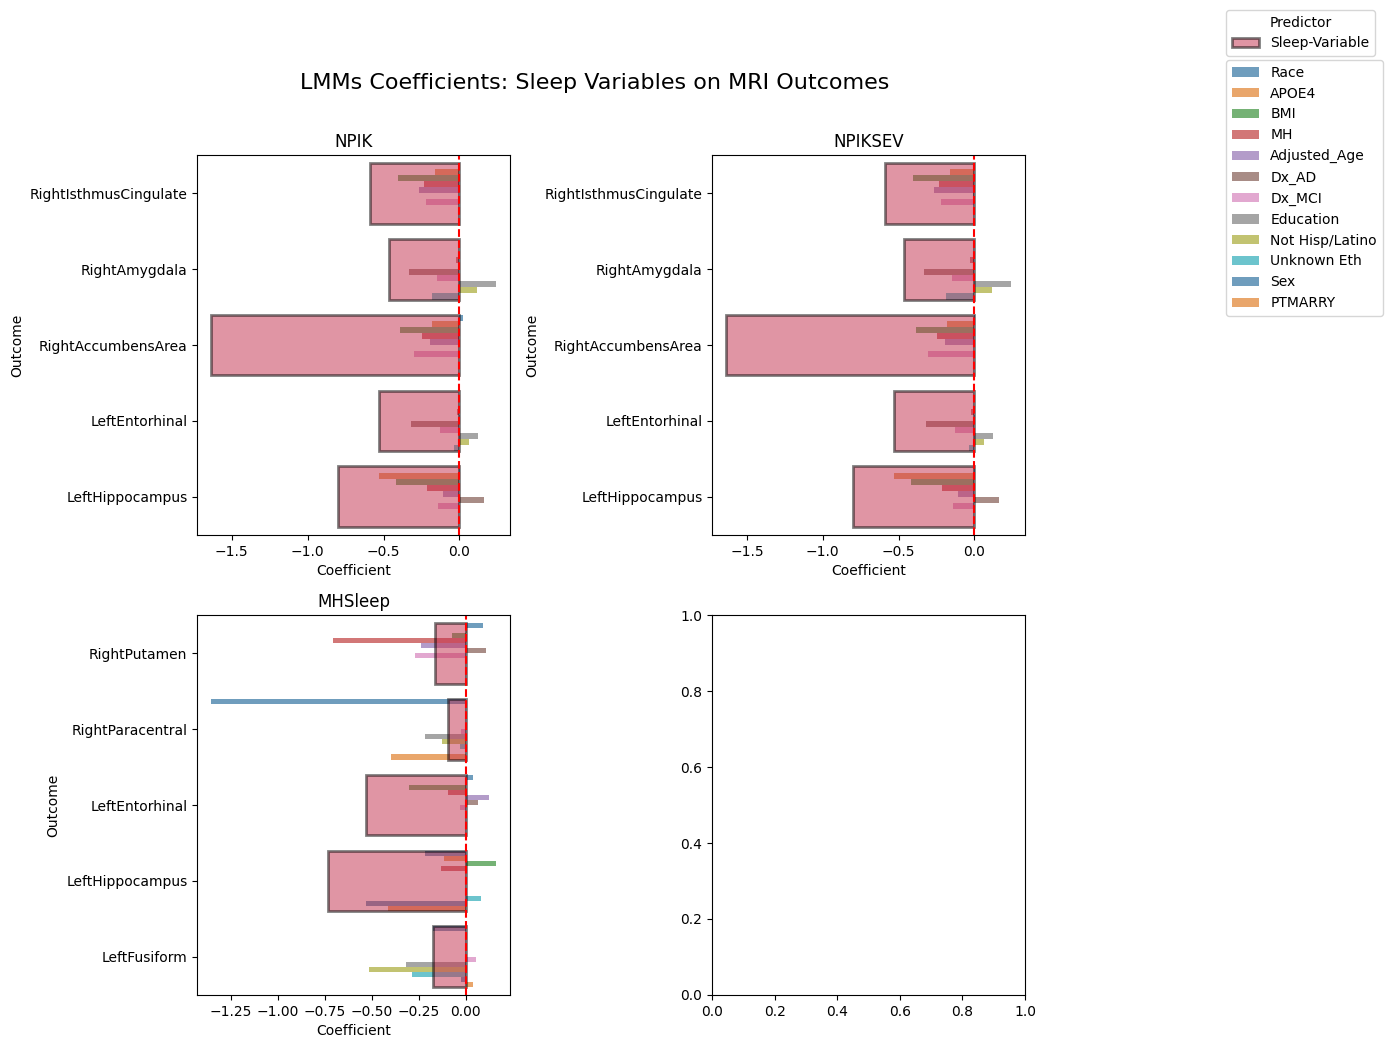

In [34]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[flat_mri['Sleep_Variable'] == sleep_var]

    top_outcomes = (
        df_plot[df_plot['Feature'] == sleep_var].sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )

    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top)

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lmms_result(df_top_all, domain='MRI')

# tables

In [36]:
pivot_df = flat_cog.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [37]:
final_df

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,ADNI_EF,-0.01 (p=0.68),-0.01 (p=0.66),0.08 (p=0.01)*
1,ADNI_EF2,-0.01 (p=0.56),-0.01 (p=0.75),0.07 (p=0.04)*
2,ADNI_LAN,-0.08 (p=0.01)*,-0.07 (p=0.00)*,0.08 (p=0.01)*
3,ADNI_MEM,-0.02 (p=0.33),-0.03 (p=0.12),0.05 (p=0.07)
4,ADNI_VS,-0.03 (p=0.51),-0.05 (p=0.14),0.04 (p=0.24)


In [38]:
pivot_df = flat_mri.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"
final_df

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,LeftEntorhinal,-0.01 (p=0.73),-0.02 (p=0.40),0.04 (p=0.24)
1,LeftFusiform,-0.03 (p=0.20),-0.02 (p=0.19),0.05 (p=0.18)
2,LeftHippocampus,0.00 (p=0.84),0.00 (p=0.73),0.08 (p=0.03)*
3,LeftInferiorLateralVentricle,0.03 (p=0.09),0.03 (p=0.00)*,-0.06 (p=0.16)
4,LeftLateralVentricle,0.01 (p=0.15),0.02 (p=0.00)*,-0.03 (p=0.43)
5,LeftMiddleTemporal,-0.03 (p=0.17),-0.03 (p=0.12),0.05 (p=0.20)
6,LeftParacentral,-0.05 (p=0.09),-0.03 (p=0.16),0.03 (p=0.40)
7,RightAccumbensArea,0.02 (p=0.53),0.00 (p=0.89),0.09 (p=0.01)*
8,RightAmygdala,-0.02 (p=0.36),-0.03 (p=0.12),0.10 (p=0.00)*


In [39]:
final_df_sorted = final_df.copy()
for col in final_df.columns[1:]:
    final_df_sorted[col] = final_df_sorted[col].sort_values(ignore_index=True)
final_df_sorted

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,LeftEntorhinal,-0.00 (p=0.88),-0.00 (p=0.88),-0.01 (p=0.82)
1,LeftFusiform,-0.00 (p=0.93),-0.00 (p=0.89),-0.02 (p=0.57)
2,LeftHippocampus,-0.01 (p=0.54),-0.01 (p=0.32),-0.03 (p=0.43)
3,LeftInferiorLateralVentricle,-0.01 (p=0.58),-0.01 (p=0.38),-0.03 (p=0.43)
4,LeftLateralVentricle,-0.01 (p=0.68),-0.01 (p=0.49),-0.03 (p=0.48)
5,LeftMiddleTemporal,-0.01 (p=0.73),-0.01 (p=0.50),-0.03 (p=0.51)
6,LeftParacentral,-0.01 (p=0.83),-0.01 (p=0.53),-0.06 (p=0.16)
7,RightAccumbensArea,-0.01 (p=0.83),-0.01 (p=0.62),0.00 (p=0.93)
8,RightAmygdala,-0.02 (p=0.36),-0.02 (p=0.19),0.01 (p=0.79)
